## Soilmoisture analysis and validation for Mozambique

<div style="line-height: 1.4;">
The aim of this notebook is to show a possible workflow for analyzing and validating soil moisture data in Mozambique retrieved from ground measurements and ASCAT satellite data. Due to the given ground measurement data we focus on 5 different areas Buzi, Chokwé, Mabalane, Mabote and Muanza.
<div>

### Workflow

1. Obtaining ground data (access, visiualize(cardtopy, histogram)... )
2. Obtaining ASCAT satellite data (access, transform data, df wide to lng, visiualize (histogram, spatial image)... )
3. Visual validation (compare histograms)
4. Statistic validation
..

In [2]:
from datetime import datetime
from importlib import reload
from time import time
import netCDF4 as nc
import ascat.read_native.ragged_array_ts as rat
import numpy as np
import xarray as xr
import geopandas as gpd
import osmnx as ox
import os

In [3]:
#At this point we want to figure out the bounding box of an area in this case Buzi in Mozambique


# Define location name
place_name = "Buzi, Mozambique"


# Get GeoDataFrame from OpenStreetMap
gdf = ox.geocode_to_gdf(place_name)

# Get bounding box
bbox = gdf.total_bounds  # [minx, miny, maxx, maxy]
print(f"Bounding Box for {place_name}: {bbox}")

Bounding Box for Buzi, Mozambique: [ 33.8931254 -20.5695588  34.8127126 -19.582687 ]


I'm not sure if cartopy is really the most elegant way to visualize in this case so I once tried it with cartopy and the other time with folium

/tmp/ipykernel_45981/1445624860.py:45: UserWarning: Legend does not support handles for FeatureArtist instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()
/tmp/ipykernel_45981/1445624860.py:45: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


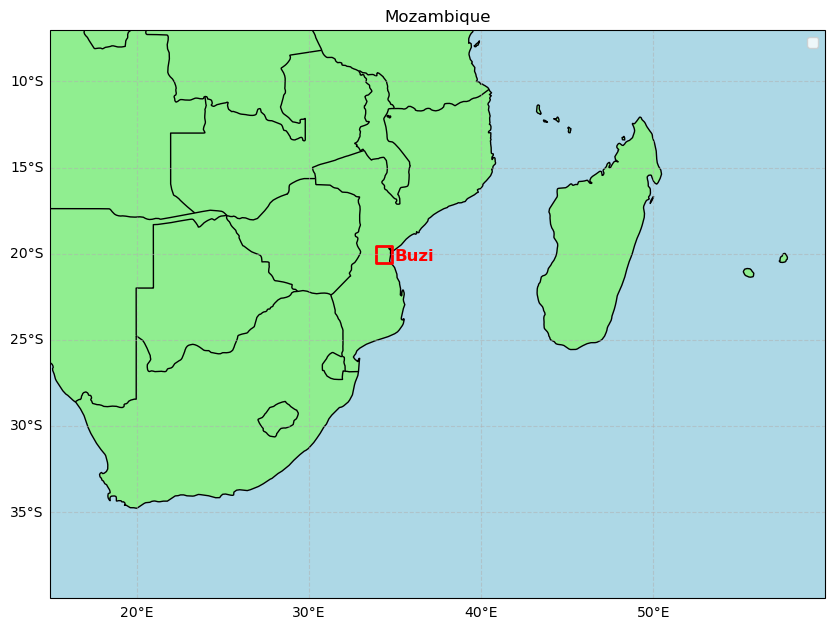

In [4]:
#In order to visualize our bounding box on the map we use the cartopy library


import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from shapely.geometry import box
import cartopy.io.shapereader as shpreader

# Original Buzi bounding box (small, precise region)
buzi_bbox = [33.8931254, 34.8127126, -20.5695588, -19.582687]  # (lon_min, lon_max, lat_min, lat_max)

# Expanded bounding box (to give context)
lon_min, lon_max = 15, 60  # Wider longitude range
lat_min, lat_max = -7, -40  # Taller latitude range

# Create figure with PlateCarree projection
fig, ax = plt.subplots(figsize=(10, 8), subplot_kw={'projection': ccrs.PlateCarree()})

# Set the map extent to the larger bounding box
ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())

# Add background map features
ax.add_feature(cfeature.BORDERS, linestyle='-')
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.LAND, facecolor='lightgreen')
ax.add_feature(cfeature.OCEAN, facecolor='lightblue')



# Add gridlines
gl = ax.gridlines(draw_labels=True, linestyle="--", alpha=0.5)
gl.right_labels = False
gl.top_labels = False


# Draw the original Buzi bounding box (in red)
buzi_box = box(buzi_bbox[0], buzi_bbox[2], buzi_bbox[1], buzi_bbox[3])
ax.add_geometries([buzi_box], crs=ccrs.PlateCarree(), facecolor='none', edgecolor='red', linewidth=2, label="Buzi Region")
ax.text(35, -20.4, "Buzi", fontsize=12, color='red', weight='bold',
        transform=ccrs.PlateCarree())

# Add title and legend
plt.title("Mozambique")
plt.legend()

# Show the map
plt.show()


In [5]:
import folium

# Create map centered on Mozambique
m = folium.Map(location=[-20, 40], zoom_start=5)

# Bounding Box [min_lon, max_lon, min_lat, max_lat]
bb = [34, 35, -21, -20]

# Define the coordinates for the bounding box
coordinates = [
    [bb[2], bb[0]],  # [min_lat, min_lon]
    [bb[2], bb[1]],  # [min_lat, max_lon]
    [bb[3], bb[1]],  # [max_lat, max_lon]
    [bb[3], bb[0]],  # [max_lat, min_lon]
    [bb[2], bb[0]],  # Closing the loop: [min_lat, min_lon]
]

# Create a polygon (bounding box) and add a fill
bounding_box = folium.Polygon(
    locations=coordinates,
    color="#39FF14",  # Border color
    weight=1,
    fill=True,  # Fill the box with color
    fill_color="#39FF14",  # Fill color
    fill_opacity=0.3  # Make the fill semi-transparent
).add_to(m)

# Add a popup to the bounding box (this will be triggered on click inside the filled area)
popup_label = "Buzi"  # Text for the popup
folium.Popup(popup_label).add_to(bounding_box)



# Display the map
m

In [6]:
#at this point we access the ascat data in form of netCDF files
#Remember: netCDF files are processed products of the ascat (advanced scatterometer) carried on th MetOp satellite 


cell_source = "/home/jlinke/shares/exchange/students/julian/ASCAT_Mozambique_data"
cell_collection = rat.CellFileCollectionStack.from_product_id(cell_source, "H121_V1.0")

/home/jlinke/anaconda3/envs/drysat/lib/python3.13/site-packages/ascat/read_native/ragged_array_ts.py:945: UserWarning: Could not determine date range for collection 'ASCAT_Mozambique_data' from directory name. Using min/max datetime from files instead.
  warnings.warn(


In [7]:
#Here we take a look at the metadata of one netCDF file called "1524.nc"

ncsource= "/home/jlinke/shares/exchange/students/julian/ASCAT_Mozambique_data/1524.nc"
ds=nc.Dataset(ncsource)
print(ds)

<class 'netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    id: 1524.nc
    date_created: 2024-09-07 07:57:49
    featureType: timeSeries
    platform: Metop-A, Metop-B, Metop-C
    product_name: Metop ASCAT Surface Soil Moisture Data Record 6.25 km sampling
    software: WARP v5.12.1
    source: ASCAT Level 1b SZF
    project: H SAF
    contact: us_hsaf@meteoam.it
    geospatial_lon_resolution: 10-15 km
    geospatial_lon_sampling: 6.25 km
    geospatial_lat_resolution: 10-15 km
    geospatial_lat_sampling: 6.25 km
    created_with_software: Python 3.11.9 and NetCDF 4.9.2
    uuid: undefined
    institution: TU Wien
    creater_name: TU Wien
    creater_url: www.tuwien.at/mg/geo/mrs
    creater_email: remote.sensing@geo.tuwien.ac.at
    cdm_data_type: Time Series
    git_hash: 84942ac
    dimensions(sizes): locations(3472), obs(38199681)
    variables(dimensions): int64 row_size(locations), float32 lon(locations), float32 lat(locations), float32 alt(locations), in

In [8]:
#We can access the variables of the netCDF file like a library object
#Be aware not to confuse the metadata from above with the variable keys
#Although the variable keys are already given in the metadata as well (see "variables(dimensions): int64 row_size(locations),...")

print(ds.variables.keys())

dict_keys(['row_size', 'lon', 'lat', 'alt', 'location_id', 'location_description', 'time', 'sat_id', 'as_des_pass', 'swath_indicator', 'surface_soil_moisture', 'surface_soil_moisture_noise', 'slope40', 'slope40_noise', 'curvature40', 'curvature40_noise', 'backscatter40', 'backscatter40_noise', 'backscatter40_flag', 'dry40', 'dry40_noise', 'wet40', 'wet40_noise', 'surface_soil_moisture_sensitivity', 'processing_flag', 'correction_flag', 'surface_state_flag'])


In [9]:
#metadata about how the time data is stored

print(ds.variables['time'])

<class 'netCDF4.Variable'>
float64 time(obs)
    standard_name: time
    long_name: time of measurement
    units: days since 1970-01-01 00:00:00
unlimited dimensions: obs
current shape = (38199681,)
filling on, default _FillValue of 9.969209968386869e+36 used


In [10]:
#As you can see above (see "units: days since 1970-01-01 00:00:00") we have a big timeframe to look at
#Just to be sure we check when the timeframe starts and ends 
#We also take a look at the time resolution of the first ten timestamps 

# Extract first time value
time_var = ds.variables["time"]  # Access time variable
time_units = time_var.units  # Get the unit string (e.g., "days since 1970-01-01")
time_value_start = time_var[0]  # First timestamp
time_value_10 = time_var[0:9]  # First few timestemps
time_value_end = time_var[-1]   # Last timestamp

# Convert to readable date
first_date = nc.num2date(time_value_start, units=time_units)
last_date = nc.num2date(time_value_end, units=time_units)
first_ten = nc.num2date(time_value_10, units=time_units)


print("First observation date:", first_date, "\n", "Last observation date:", last_date,"\n")
print("First 10 observation dates:") 


for i in range(len(first_ten)):
    print(first_ten[i])

# Close dataset
#ds.close()

First observation date: 2007-01-01 06:39:24.908000 
 Last observation date: 2024-05-31 20:07:09.816000 

First 10 observation dates:
2007-01-01 06:39:24.908000
2007-01-02 20:22:02.290000
2007-01-03 07:38:00.391000
2007-01-05 06:56:39.321000
2007-01-05 19:20:04.241000
2007-01-06 06:36:02.554000
2007-01-07 20:18:40.785000
2007-01-08 07:34:37.220000
2007-01-09 19:37:23.780000


In [11]:
print(ds.variables.keys())

dict_keys(['row_size', 'lon', 'lat', 'alt', 'location_id', 'location_description', 'time', 'sat_id', 'as_des_pass', 'swath_indicator', 'surface_soil_moisture', 'surface_soil_moisture_noise', 'slope40', 'slope40_noise', 'curvature40', 'curvature40_noise', 'backscatter40', 'backscatter40_noise', 'backscatter40_flag', 'dry40', 'dry40_noise', 'wet40', 'wet40_noise', 'surface_soil_moisture_sensitivity', 'processing_flag', 'correction_flag', 'surface_state_flag'])


In [12]:
#We still working with only one netCDF file called "1524.nc"
#Now we gonna take a look at the minimum and maximum latitude and longitude 
lat_var=ds.variables['lat']
lon_var=ds.variables['lon']

print("Max latitude:",max(lat_var),"Min latitude:",min(lat_var),"\n")
print("Max longitude:",max(lon_var),"Min longitude:",min(lon_var))



Max latitude: -25.000368 Min latitude: -29.997095 

Max longitude: 34.027664 Min longitude: 30.000797


In [13]:
#Above we see that the area that is covered by our data is quite big
#Especially compared to our bounding box for Buzi f.e.
#In order to avoid our code to crash due to overload, we have to filter out data and make it smaller
#We do this with the help of the xarray library

In [ ]:
xrds=xr.open_dataset("/home/jlinke/shares/exchange/students/julian/ASCAT_Mozambique_data/1524.nc",
                     chunks={"time":100})

xrds

<xarray.Dataset> Size: 5GB
Dimensions:                            (locations: 3472, obs: 38199681)
Coordinates:
    lon                                (locations) float32 14kB dask.array<chunksize=(3472,), meta=np.ndarray>
    lat                                (locations) float32 14kB dask.array<chunksize=(3472,), meta=np.ndarray>
    time                               (obs) datetime64[ns] 306MB dask.array<chunksize=(512,), meta=np.ndarray>
Dimensions without coordinates: locations, obs
Data variables: (12/24)
    row_size                           (locations) int64 28kB dask.array<chunksize=(3472,), meta=np.ndarray>
    alt                                (locations) float32 14kB dask.array<chunksize=(3472,), meta=np.ndarray>
    location_id                        (locations) int64 28kB dask.array<chunksize=(3472,), meta=np.ndarray>
    location_description               (locations) <U1 14kB dask.array<chunksize=(3472,), meta=np.ndarray>
    sat_id                             (obs) float32 153MB dask.array<chunksize=(4096,), meta=np.ndarray>
    as_des_pass                        (obs) float32 153MB dask.array<chunksize=(4096,), meta=np.ndarray>
    ...                                 ...
    wet40                              (obs) float64 306MB dask.array<chunksize=(1003,), meta=np.ndarray>
    wet40_noise                        (obs) float64 306MB dask.array<chunksize=(1003,), meta=np.ndarray>
    surface_soil_moisture_sensitivity  (obs) float64 306MB dask.array<chunksize=(1003,), meta=np.ndarray>
    processing_flag                    (obs) float32 153MB dask.array<chunksize=(4012,), meta=np.ndarray>
    correction_flag                    (obs) float32 153MB dask.array<chunksize=(4012,), meta=np.ndarray>
    surface_state_flag                 (obs) float32 153MB dask.array<chunksize=(4012,), meta=np.ndarray>
Attributes: (12/21)
    id:                         1524.nc
    date_created:               2024-09-07 07:57:49
    featureType:                timeSeries
    platform:                   Metop-A, Metop-B, Metop-C
    product_name:               Metop ASCAT Surface Soil Moisture Data Record...
    software:                   WARP v5.12.1
    ...                         ...
    institution:                TU Wien
    creater_name:               TU Wien
    creater_url:                www.tuwien.at/mg/geo/mrs
    creater_email:              remote.sensing@geo.tuwien.ac.at
    cdm_data_type:              Time Series
    git_hash:                   84942ac

In [24]:
min_lat=xrds.lat.min().values
max_lat=xrds.lat.max().values
min_lon=xrds.lon.min().values
min_lon=xrds.lon.max().values

print(min_lat)
print(max_lat)
print(min_lon)
print(max_lon)

-29.997095
9.96921e+36
9.96921e+36
35.6973266


In [ ]:
#Seemingly we have to filter the NaNs in the xarray 

In [25]:
#this part might no be needed

# Define location name

area_dict = {"Buzi":{"lat":[],'lon':[]},"Chokwé":{"lat":[],'lon':[]},"Mabalane":{"lat":[],'lon':[]},
             "Mabote":{"lat":[],'lon':[]},"Muanza":{"lat":[],'lon':[]}}

for name in area_dict:
    
    gdf=ox.geocode_to_gdf(name)
    bbox = gdf.total_bounds
    min_lon, min_lat, max_lon, max_lat = bbox
    area_dict[name]["lon"].extend([min_lon, max_lon]) 
    area_dict[name]["lat"].extend([min_lat, max_lat])
    
area_dict


{'Buzi': {'lat': [np.float64(-20.5695588), np.float64(-19.582687)],
  'lon': [np.float64(33.8931254), np.float64(34.8127126)]},
 'Chokwé': {'lat': [np.float64(-24.8651389), np.float64(-24.1120627)],
  'lon': [np.float64(32.5596257), np.float64(33.5225846)]},
 'Mabalane': {'lat': [np.float64(-24.1967515), np.float64(-22.9668694)],
  'lon': [np.float64(32.2377105), np.float64(33.2483723)]},
 'Mabote': {'lat': [np.float64(-22.9057726), np.float64(-21.3023939)],
  'lon': [np.float64(33.1611587), np.float64(34.6342067)]},
 'Muanza': {'lat': [np.float64(-19.5313462), np.float64(-18.6416478)],
  'lon': [np.float64(34.4736235), np.float64(35.6973266)]}}

In [26]:
#this part might no be needed

# Path to the directory
directory_path = "/home/jlinke/shares/exchange/students/julian/ASCAT_Mozambique_data/"

# List all files in the directory
files = os.listdir(directory_path)

print(files)

# Loop through the files
for file in files:
    
    ncsource= f"/home/jlinke/shares/exchange/students/julian/ASCAT_Mozambique_data/{file}"
    ds=nc.Dataset(ncsource)
    list=ds.variables.keys()
    print(list)
        

['1524.nc', '1525.nc', '1526.nc', '1527.nc', '1561.nc', '1562.nc', '1563.nc']
dict_keys(['row_size', 'lon', 'lat', 'alt', 'location_id', 'location_description', 'time', 'sat_id', 'as_des_pass', 'swath_indicator', 'surface_soil_moisture', 'surface_soil_moisture_noise', 'slope40', 'slope40_noise', 'curvature40', 'curvature40_noise', 'backscatter40', 'backscatter40_noise', 'backscatter40_flag', 'dry40', 'dry40_noise', 'wet40', 'wet40_noise', 'surface_soil_moisture_sensitivity', 'processing_flag', 'correction_flag', 'surface_state_flag'])
dict_keys(['row_size', 'lon', 'lat', 'alt', 'location_id', 'location_description', 'time', 'sat_id', 'as_des_pass', 'swath_indicator', 'surface_soil_moisture', 'surface_soil_moisture_noise', 'slope40', 'slope40_noise', 'curvature40', 'curvature40_noise', 'backscatter40', 'backscatter40_noise', 'backscatter40_flag', 'dry40', 'dry40_noise', 'wet40', 'wet40_noise', 'surface_soil_moisture_sensitivity', 'processing_flag', 'correction_flag', 'surface_state_flag

In [13]:
#so at first we tried the bounding box for whole Mozambique but that always crashed
#lets try it with the bounding box just for the area of Buzi

#bounds = (-21,-20,34,35) #latmin, latmax, lonmin, lonmax
bounds = (-27,-10,30,41) #latmin, latmax, lonmin, lonmax

output_bbox = cell_collection.read(bbox=bounds)

#The timeframe we choose for now is a random date until the end of the dataset
#random_date= np.datetime64("2024-05-30 20:07:09.816000")
#dates = (random_date, np.datetime64(last_date))

# Now apply the time range filter
#dates = (random_date, np.datetime64(last_date))
#output_bbox_filtered_by_time = output_bbox.sel(time=slice(dates[0], dates[1]))

#output_bbox_filtered_by_time

#output_bbox = cell_collection.read(bbox=bounds, date_range=dates)
#output_bbox

/home/jlinke/anaconda3/envs/drysat/lib/python3.13/site-packages/ascat/read_native/ragged_array_ts.py:1210: RuntimeWarning: I/O error(2): No such file or directory, /home/jlinke/shares/exchange/students/julian/ASCAT_Mozambique_data/1560.nc
  if self._open(cells=cell):
/home/jlinke/anaconda3/envs/drysat/lib/python3.13/site-packages/ascat/read_native/ragged_array_ts.py:1210: RuntimeWarning: I/O error(2): No such file or directory, /home/jlinke/shares/exchange/students/julian/ASCAT_Mozambique_data/1596.nc
  if self._open(cells=cell):
/home/jlinke/anaconda3/envs/drysat/lib/python3.13/site-packages/ascat/read_native/ragged_array_ts.py:1210: RuntimeWarning: I/O error(2): No such file or directory, /home/jlinke/shares/exchange/students/julian/ASCAT_Mozambique_data/1597.nc
  if self._open(cells=cell):
/home/jlinke/anaconda3/envs/drysat/lib/python3.13/site-packages/ascat/read_native/ragged_array_ts.py:1210: RuntimeWarning: I/O error(2): No such file or directory, /home/jlinke/shares/exchange/stu

KeyboardInterrupt: 